In [17]:
# Install library
!pip install statsmodels -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Import datasheet
url = ('https://raw.githubusercontent.com/Ali-Aryo/time-series-regression-model/refs/heads/main/ChickData.csv')

# Read the CSV - note: file has metadata rows before actual data
import io
import requests

response = requests.get(url)
lines = response.text.strip().split('\n')

# Find header row containing "Geography"
header_idx = None
for i, line in enumerate(lines):
    if 'Geography' in line and 'June' in line:
        header_idx = i
        break

csv_text = '\n'.join(lines[header_idx:])
df = pd.read_csv(io.StringIO(csv_text))

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
df


Data loaded successfully!
Shape: (2, 314)


,Geography,"June 8, 2019","June 15, 2019","June 22, 2019","June 29, 2019","July 6, 2019","July 13, 2019","July 20, 2019","July 27, 2019","August 3, 2019",...,"March 29, 2025","April 5, 2025","April 12, 2025","April 19, 2025","April 26, 2025","May 3, 2025","May 10, 2025","May 17, 2025","May 24, 2025","May 31, 2025"
0,Quebec,135,126,178,127,291,248,92,53,210,...,200,245,297,154,287,265,198,198,189,180
1,Ontario,250,288,247,362,245,239,359,189,362,...,398,204,176,297,265,398,446,468,354,414


In [19]:
# Reshape from wide to long format for time series modeling
df_long = df.melt(id_vars=['Geography'],
                  var_name='date',
                  value_name='value')

# Convert and clean data
df_long['date'] = pd.to_datetime(df_long['date'])
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')
df_long = df_long.sort_values(['Geography', 'date']).reset_index(drop=True)

# Fill missing values
df_long['value'] = df_long.groupby('Geography')['value'].ffill()

print(f"Reshaped data: {df_long.shape}")
print(f"\nDate range: {df_long['date'].min()} to {df_long['date'].max()}")
print(f"Missing values: {df_long['value'].isna().sum()}")

df_long.head(10)


Reshaped data: (626, 3)

Date range: 2019-06-08 00:00:00 to 2025-05-31 00:00:00
Missing values: 0


,Geography,date,value
0,Ontario,2019-06-08,250.0
1,Ontario,2019-06-15,288.0
2,Ontario,2019-06-22,247.0
3,Ontario,2019-06-29,362.0
4,Ontario,2019-07-06,245.0
5,Ontario,2019-07-13,239.0
6,Ontario,2019-07-20,359.0
7,Ontario,2019-07-27,189.0
8,Ontario,2019-08-03,362.0
9,Ontario,2019-08-10,117.0


In [20]:
# Prepare Quebec data
quebec_data = df_long[df_long['Geography'] == 'Quebec'].copy()
quebec_data = quebec_data.set_index('date')['value']

# Prepare Ontario data
ontario_data = df_long[df_long['Geography'] == 'Ontario'].copy()
ontario_data = ontario_data.set_index('date')['value']

print("QUEBEC:")
print(f"  Observations: {len(quebec_data)}")
print(f"  Mean: {quebec_data.mean():.1f}")
print(f"  Std: {quebec_data.std():.1f}")

print("\nONTARIO:")
print(f"  Observations: {len(ontario_data)}")
print(f"  Mean: {ontario_data.mean():.1f}")
print(f"  Std: {ontario_data.std():.1f}")


QUEBEC:
  Observations: 313
  Mean: 149.8
  Std: 72.6

ONTARIO:
  Observations: 313
  Mean: 258.5
  Std: 89.5


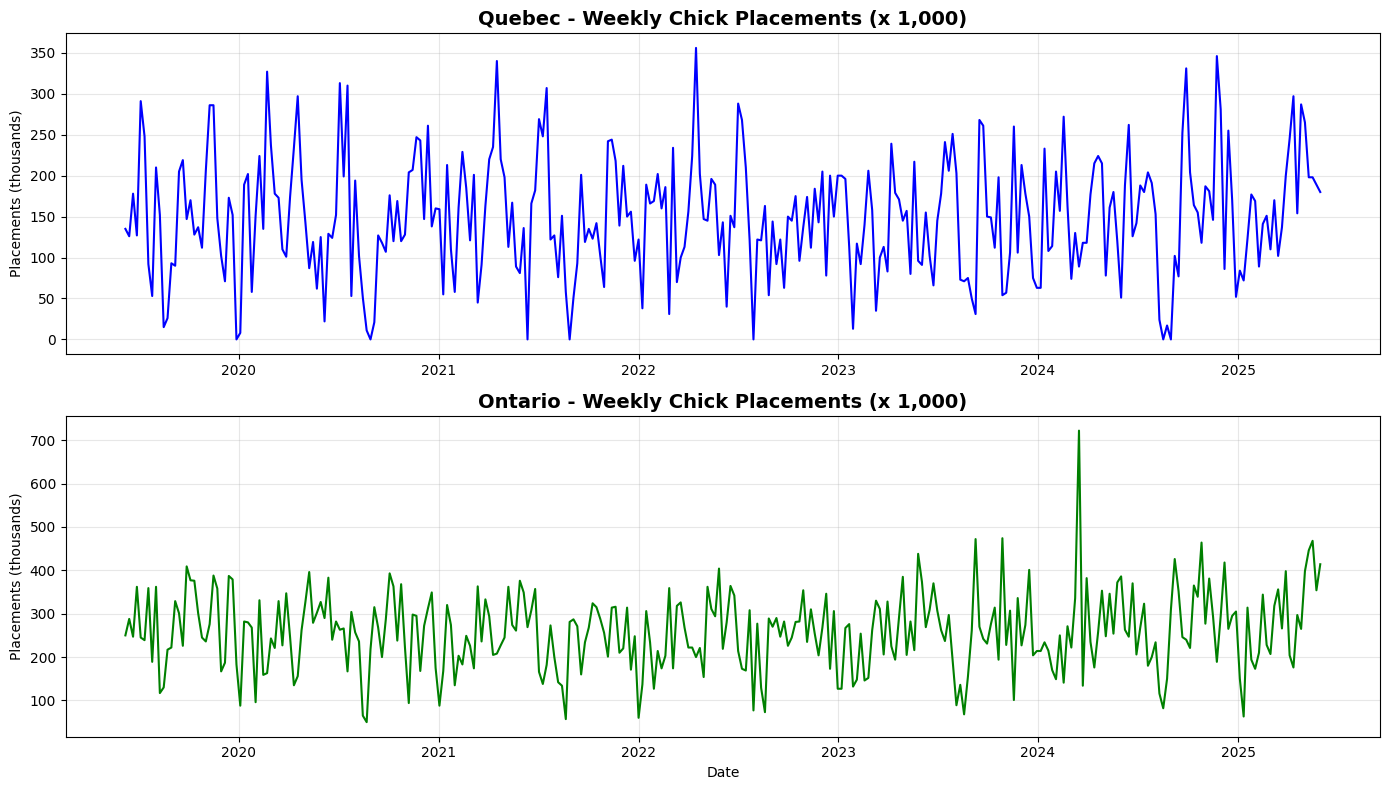

In [21]:
# Plot both provinces Matplotlib
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Quebec
axes[0].plot(quebec_data.index, quebec_data.values, color='blue', linewidth=1.5)
axes[0].set_title('Quebec - Weekly Chick Placements (x 1,000)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Placements (thousands)')
axes[0].grid(True, alpha=0.3)

# Ontario
axes[1].plot(ontario_data.index, ontario_data.values, color='green', linewidth=1.5)
axes[1].set_title('Ontario - Weekly Chick Placements (x 1,000)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Placements (thousands)')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
print("="*70)
print("TRAINING SARIMAX MODEL FOR QUEBEC")
print("="*70)

# Fit SARIMAX model with weekly seasonality (52 weeks)
#Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors
mod_quebec = SARIMAX(
    quebec_data,
    order=(1, 1, 1),              # ARIMA(1,1,1) = (AR I MA)
    seasonal_order=(1, 1, 1, 52), # Seasonal component with 52 weeks
    enforce_stationarity=False,
    enforce_invertibility=False
)

res_quebec = mod_quebec.fit(disp=False)

print("✓ Quebec model fitted successfully!\n")
print(res_quebec.summary())


TRAINING SARIMAX MODEL FOR QUEBEC
✓ Quebec model fitted successfully!

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  313
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1161.130
Date:                            Thu, 02 Oct 2025   AIC                           2332.259
Time:                                    14:40:24   BIC                           2348.899
Sample:                                06-08-2019   HQIC                          2338.989
                                     - 05-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1651      0.068      2.415

In [23]:
print("="*70)
print("TRAINING SARIMAX MODEL FOR ONTARIO")
print("="*70)

# Fit SARIMAX model
mod_ontario = SARIMAX(
    ontario_data,
    order=(1, 1, 1), #non seasonal, (1,1,1) is a common starting point - would test for more with more time
    seasonal_order=(1, 1, 1, 52), #seasonal 52 weeks for a year
    enforce_stationarity=False,
    enforce_invertibility=False
)

res_ontario = mod_ontario.fit(disp=False)

print("✓ Ontario model fitted successfully!\n")
print(res_ontario.summary())


TRAINING SARIMAX MODEL FOR ONTARIO
✓ Ontario model fitted successfully!

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  313
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1190.726
Date:                            Thu, 02 Oct 2025   AIC                           2391.452
Time:                                    14:41:10   BIC                           2408.091
Sample:                                06-08-2019   HQIC                          2398.181
                                     - 05-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1685      0.079     -2.1

In [24]:
# Forecast from May 31, 2025 through end of year
forecast_start = pd.Timestamp('2025-05-31')
forecast_end = pd.Timestamp('2025-12-27')
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='W-SAT')
n_steps = len(forecast_dates)

print(f"Generating {n_steps} weeks of forecasts from {forecast_start.date()} to {forecast_end.date()}")

# Quebec forecast
forecast_quebec = res_quebec.forecast(steps=n_steps)
forecast_quebec.index = forecast_dates

# Ontario forecast
forecast_ontario = res_ontario.forecast(steps=n_steps)
forecast_ontario.index = forecast_dates

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'Quebec': forecast_quebec.values,
    'Ontario': forecast_ontario.values
})

print("\nForecast Preview:")
forecast_df.head(10)


Generating 31 weeks of forecasts from 2025-05-31 to 2025-12-27

Forecast Preview:


,date,Quebec,Ontario
0,2025-05-31,150.139371,288.374910
1,2025-06-07,190.442376,304.275766
2,2025-06-14,129.528633,386.671884
3,2025-06-21,209.552503,256.074446
4,2025-06-28,216.709974,270.867491
5,2025-07-05,224.340264,294.813069
6,2025-07-12,168.570955,257.117761
7,2025-07-19,177.496125,211.337129
8,2025-07-26,155.090008,218.756463
9,2025-08-02,73.052056,145.898877


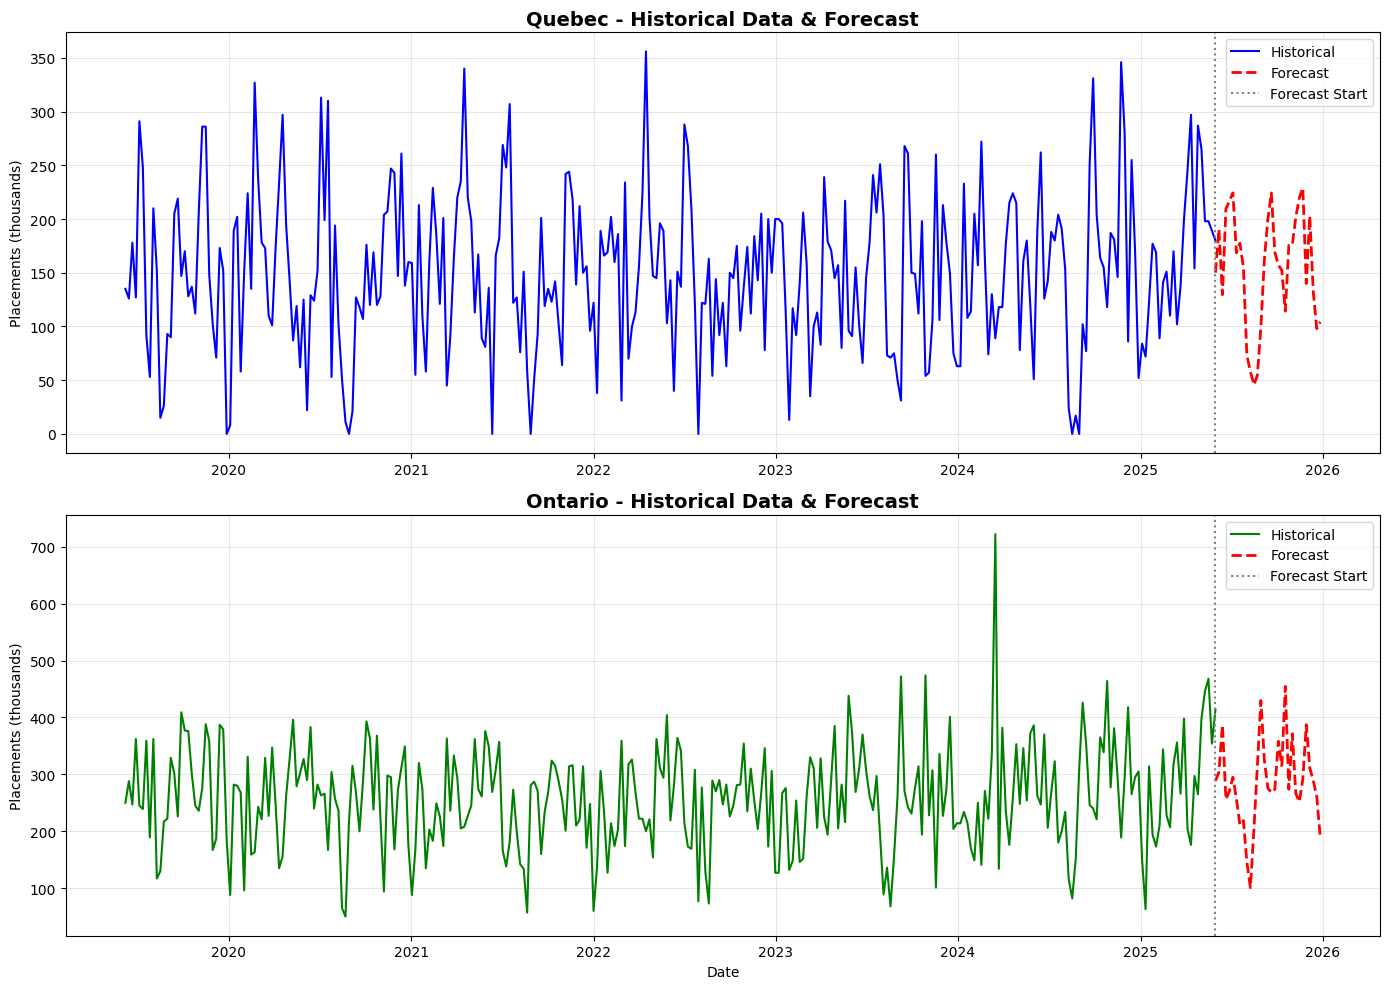

In [25]:
# Plot historical data + forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Quebec
axes[0].plot(quebec_data.index, quebec_data.values, label='Historical', color='blue', linewidth=1.5)
axes[0].plot(forecast_dates, forecast_quebec.values, label='Forecast', color='red', linestyle='--', linewidth=2)
axes[0].axvline(x=forecast_start, color='gray', linestyle=':', label='Forecast Start')
axes[0].set_title('Quebec - Historical Data & Forecast', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Placements (thousands)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Ontario
axes[1].plot(ontario_data.index, ontario_data.values, label='Historical', color='green', linewidth=1.5)
axes[1].plot(forecast_dates, forecast_ontario.values, label='Forecast', color='red', linestyle='--', linewidth=2)
axes[1].axvline(x=forecast_start, color='gray', linestyle=':', label='Forecast Start')
axes[1].set_title('Ontario - Historical Data & Forecast', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Placements (thousands)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Save forecast to CSV
forecast_df.to_csv('chick_placement_forecast_2025.csv', index=False)
print("✓ Forecast saved to 'chick_placement_forecast_2025.csv'")

# Display final forecast table
forecast_df


✓ Forecast saved to 'chick_placement_forecast_2025.csv'


,date,Quebec,Ontario
0,2025-05-31,150.139371,288.374910
1,2025-06-07,190.442376,304.275766
2,2025-06-14,129.528633,386.671884
3,2025-06-21,209.552503,256.074446
4,2025-06-28,216.709974,270.867491
5,2025-07-05,224.340264,294.813069
6,2025-07-12,168.570955,257.117761
7,2025-07-19,177.496125,211.337129
8,2025-07-26,155.090008,218.756463
9,2025-08-02,73.052056,145.898877
